# Problem statement

https://www.sciencedirect.com/science/article/pii/S0021999118307125

\begin{equation}
    \begin{aligned}
        u_t +uu_{x}&=\frac{0.01}{\pi}u_{xx},\\ 
        u(0,x)&=-sin(\pi x),\\
        u(t,-1)&=u(t,1)=0\\
\end{aligned}
\end{equation}
 $\text{where, } x \in [-1,1] \text{ and } t \in [0,1]$.

# imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from random import uniform
import pickle
import FINDER_core

Using cuda device for FINDER


In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


# PINN class

In [3]:
class BurgersPINN(nn.Module):
    def __init__(self, X_u, u, X_f):
        super(BurgersPINN, self).__init__()
        # x & t from boundary conditions:
        self.x_u = torch.tensor(X_u[:, 0].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True).to(device)
        self.t_u = torch.tensor(X_u[:, 1].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True).to(device)

        # x & t from collocation points:
        self.x_f = torch.tensor(X_f[:, 0].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True).to(device)
        self.t_f = torch.tensor(X_f[:, 1].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True).to(device)

        # boundary solution:
        self.u = torch.tensor(u, dtype=torch.float32).to(device)

        # null vector to test against f:
        self.null =  torch.zeros((self.x_f.shape[0], 1)).to(device)

        # initialize net:
        self.create_net()
        #self.net.apply(self.init_weights)

        # this optimizer updates the weights and biases of the net:
        self.optimizer_FINDER = FINDER_core.FINDER(self, clamps = [0.0001, 0.0001])
        self.optimizer_adam = torch.optim.Adam(self.parameters(), 1e-3)
        # typical MSE loss (this is a function):
        self.loss = nn.MSELoss()

        # loss :
        self.ls = 0

        # iteration number:
        self.iter = 0

    def create_net(self):
        """ net takes a batch of two inputs: (n, 2) --> (n, 1) """
        self.net = nn.Sequential(
            nn.Linear(2, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 1)).to(device)
        
    def net_u(self, x, t):
        u = self.net( torch.hstack((x, t)) )
        return u

    def net_f(self, x, t):
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True)[0]
        
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True)[0]
        
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True)[0]

        f = u_t + (u * u_x) - (nu * u_xx)

        return f
        
    def plot(self):
        """ plot the solution on new data """
        
        import matplotlib.pyplot as plt
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        
        x = torch.linspace(-1, 1, 200)
        t = torch.linspace( 0, 1, 100)

        # x & t grids:
        X, T = torch.meshgrid(x, t)

        # x & t columns:
        xcol = X.reshape(-1, 1)
        tcol = T.reshape(-1, 1)

        # one large column:
        usol = self.net_u(xcol, tcol)

        # reshape solution:
        U = usol.reshape(x.numel(), t.numel())

        # transform to numpy:
        xnp = x.numpy()
        tnp = t.numpy()
        Unp = U.detach().numpy()

        # plot:
        fig = plt.figure(figsize=(9, 4.5))
        ax = fig.add_subplot(111)

        h = ax.imshow(Unp,
                      interpolation='nearest',
                      cmap='rainbow', 
                      extent=[tnp.min(), tnp.max(), xnp.min(), xnp.max()], 
                      origin='lower', aspect='auto')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.10)
        cbar = fig.colorbar(h, cax=cax)
        cbar.ax.tick_params(labelsize=10)
        plt.show()

    def loss_grad(self, param, inputs = None, labels = None, no_grad = False):
        
        '''
        constructing xmean to match the shape of parameter in model.parameters
        '''
        torch.nn.utils.vector_to_parameters(param, self.net.parameters())
    
        '''
        loss
        '''
        # reset gradients to zero:
        self.zero_grad()
        
        # u & f predictions:
        u_prediction = self.net_u(self.x_u, self.t_u)
        f_prediction = self.net_f(self.x_f, self.t_f)
        if no_grad == False:
            # losses:
            u_loss = self.loss(u_prediction, self.u)
            f_loss = self.loss(f_prediction, self.null)
            self.ls = u_loss + f_loss
        
            '''
            backward pass
            '''
        
            self.ls.backward()
        
            '''
            grads
            '''
            self.grads = []
            for param in self.net.parameters():
                self.grads.append(param.grad.view(-1))
            self.grads = torch.cat(self.grads)
            
            return self.ls.detach().item(), self.grads
        else:
            with torch.no_grad():
                u_loss = self.loss(u_prediction, self.u)
                f_loss = self.loss(f_prediction, self.null)
                self.ls = u_loss + f_loss
                return self.ls.detach().item()
                

# Datapoints, constants

In [4]:
nu = 0.01 / np.pi         # constant in the diff. equation
N_u = 100                 # number of data points in the boundaries
N_f = 10000               # number of collocation points

In [5]:
x_upper = np.ones((N_u//4, 1), dtype=np.float32)
x_lower = np.ones((N_u//4, 1), dtype=np.float32) * (-1)
t_zero = np.zeros((N_u//2, 1), dtype=np.float32)

In [6]:
t_upper = np.random.rand(N_u//4, 1).astype(np.float32)
t_lower = np.random.rand(N_u//4, 1).astype(np.float32)
x_zero = (-1) + np.random.rand(N_u//2, 1).astype(np.float32) * (1 - (-1))

In [7]:
# stack uppers, lowers and zeros:
X_upper = np.hstack( (x_upper, t_upper), dtype = np.float32 )
X_lower = np.hstack( (x_lower, t_lower), dtype = np.float32 )
X_zero = np.hstack( (x_zero, t_zero), dtype = np.float32 )

In [8]:
# each one of these three arrays haS 2 columns, 
# now we stack them vertically, the resulting array will also have 2 
# columns and 100 rows:
X_u_train = np.vstack( (X_upper, X_lower, X_zero), dtype = np.float32 )

In [9]:
# shuffle X_u_train:
index = np.arange(0, N_u)
np.random.shuffle(index)
X_u_train = X_u_train[index, :]

In [10]:
# make X_f_train:
X_f_train = np.zeros((N_f, 2), dtype = np.float32)

In [11]:
for row in range(N_f):
    x = uniform(-1, 1)  # x range
    t = uniform( 0, 1)  # t range

    X_f_train[row, 0] = x 
    X_f_train[row, 1] = t

In [12]:
# add the boundary points to the collocation points:
X_f_train = np.vstack( (X_f_train, X_u_train), dtype = np.float32 )

In [13]:
# make u_train
u_upper =  np.zeros((N_u//4, 1), dtype = np.float32)
u_lower =  np.zeros((N_u//4, 1), dtype = np.float32) 
u_zero = -np.sin(np.pi * x_zero).astype(np.float32)


In [14]:
# stack them in the same order as X_u_train was stacked:
u_train = np.vstack( (u_upper, u_lower, u_zero), dtype = np.float32 )

In [15]:
# match indices with X_u_train
u_train = u_train[index, :]

# model

In [16]:
# pass data sets to the PINN:
pinn = BurgersPINN(X_u_train, u_train, X_f_train)

In [17]:
start = torch.nn.utils.parameters_to_vector(pinn.net.parameters())

In [18]:
print(start.shape)

torch.Size([3441])


# train loop with FINDER

In [19]:
tic = time.time()
fx = []
pinn.train()
for epoch in range(10000):
    loss_value = pinn.optimizer_FINDER.step(inputs=None)
    print(f'Epoch [{epoch}] loss: {loss_value:.6f}')
    fx.append(loss_value)
    if loss_value < 1e-3:
        break
toc = time.time()
print(toc - tic)

Epoch [0] loss: 0.231954
Epoch [1] loss: 0.231703
Epoch [2] loss: 0.231071
Epoch [3] loss: 0.229248
Epoch [4] loss: 0.205273
Epoch [5] loss: 0.187414
Epoch [6] loss: 0.179207
Epoch [7] loss: 0.168796
Epoch [8] loss: 0.145307
Epoch [9] loss: 0.143552
Epoch [10] loss: 0.142303
Epoch [11] loss: 0.140891
Epoch [12] loss: 0.136683
Epoch [13] loss: 0.136543
Epoch [14] loss: 0.134030
Epoch [15] loss: 0.133101
Epoch [16] loss: 0.132030
Epoch [17] loss: 0.129422
Epoch [18] loss: 0.124043
Epoch [19] loss: 0.122193
Epoch [20] loss: 0.119952
Epoch [21] loss: 0.115020
Epoch [22] loss: 0.105331
Epoch [23] loss: 0.103863
Epoch [24] loss: 0.099589
Epoch [25] loss: 0.090656
Epoch [26] loss: 0.088014
Epoch [27] loss: 0.078837
Epoch [28] loss: 0.078745
Epoch [29] loss: 0.078558
Epoch [30] loss: 0.077512
Epoch [31] loss: 0.077400
Epoch [32] loss: 0.075615
Epoch [33] loss: 0.072471
Epoch [34] loss: 0.067493
Epoch [35] loss: 0.064537
Epoch [36] loss: 0.063476
Epoch [37] loss: 0.062334
Epoch [38] loss: 0.059

# testing with FINDER

/home/uttam/miniforge3/envs/torch/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


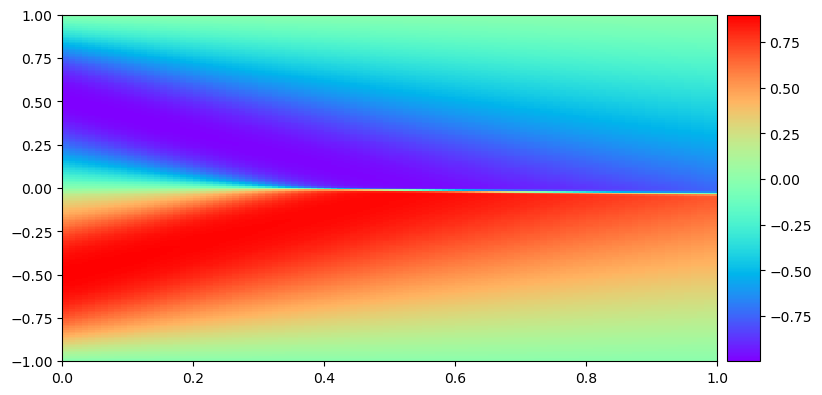

In [20]:
pinn.cpu().plot()

# training with Adam

In [21]:
tic = time.time()
fx_adam = []
torch.nn.utils.vector_to_parameters(start, pinn.net.parameters())
for epoch in range(10000):
    loss_value = pinn.loss_grad(torch.nn.utils.parameters_to_vector(pinn.parameters()), 
                                inputs=None, no_grad=False)[0]
    pinn.optimizer_adam.step()
    print(f'Epoch [{epoch}] loss: {loss_value:.6f}')
    fx_adam.append(loss_value)
    if loss_value < 1e-3:
        break
toc = time.time()
print(toc - tic)

Epoch [0] loss: 0.248669
Epoch [1] loss: 0.242774
Epoch [2] loss: 0.238243
Epoch [3] loss: 0.235002
Epoch [4] loss: 0.232931
Epoch [5] loss: 0.231850
Epoch [6] loss: 0.231510
Epoch [7] loss: 0.231601
Epoch [8] loss: 0.231799
Epoch [9] loss: 0.231837
Epoch [10] loss: 0.231560
Epoch [11] loss: 0.230929
Epoch [12] loss: 0.229981
Epoch [13] loss: 0.228790
Epoch [14] loss: 0.227438
Epoch [15] loss: 0.225988
Epoch [16] loss: 0.224480
Epoch [17] loss: 0.222923
Epoch [18] loss: 0.221298
Epoch [19] loss: 0.219570
Epoch [20] loss: 0.217691
Epoch [21] loss: 0.215612
Epoch [22] loss: 0.213294
Epoch [23] loss: 0.210717
Epoch [24] loss: 0.207896
Epoch [25] loss: 0.204893
Epoch [26] loss: 0.201828
Epoch [27] loss: 0.198887
Epoch [28] loss: 0.196325
Epoch [29] loss: 0.194429
Epoch [30] loss: 0.193441
Epoch [31] loss: 0.193385
Epoch [32] loss: 0.193904
Epoch [33] loss: 0.194345
Epoch [34] loss: 0.194156
Epoch [35] loss: 0.193195
Epoch [36] loss: 0.191668
Epoch [37] loss: 0.189916
Epoch [38] loss: 0.188

# testing with Adam

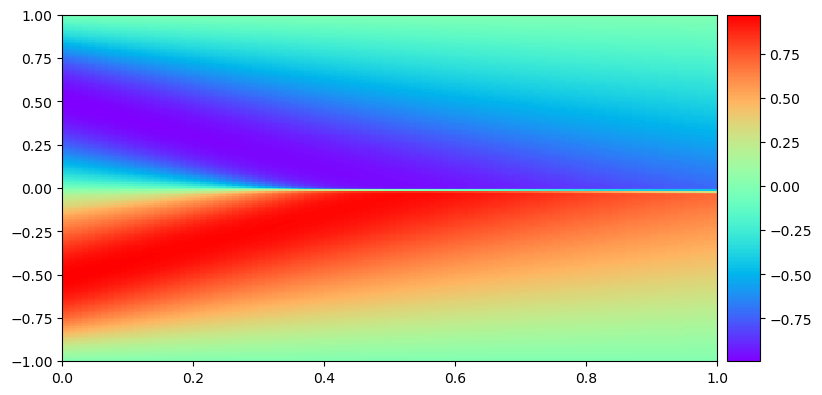

In [22]:
pinn.cpu().plot()

# plotting

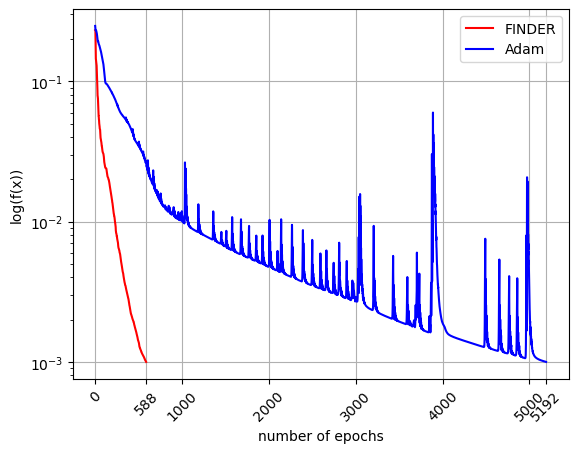

In [23]:
ax = plt.axes()
# ax.set_facecolor('bisque')
plt.plot(fx,'r', label = "FINDER")
plt.plot(fx_adam,'b', label = "Adam")
plt.xticks([0,1000, 2000,3000,4000,5000,len(fx), len(fx_adam)], rotation = 45)
plt.ylabel('log(f(x))')
plt.xlabel('number of epochs')
plt.legend()
plt.yscale('log')
plt.grid()